In [1]:
# imports
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
# DEVICE = 'cpu'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else
                      "cpu")


print(DEVICE)

mps


In [3]:
import requests
import json

In [4]:
# скачиваем файл с классами ImageNet
# https://www.image-net.org/index.php

# адрес для скачивания файла
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
response = requests.get(url)

# Загружаем JSON-данные напрямую в словарь
labels = response.json()

In [13]:
labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [5]:
# функция декодировки
decode = lambda x: labels[str(x)][1]
print(decode(0))
print(decode(1))
print(decode(100))
print(decode(220))

tench
goldfish
black_swan
Sussex_spaniel


In [6]:
from torchvision.models import vgg16, VGG16_Weights

model_VGG = vgg16(weights=VGG16_Weights.DEFAULT)

In [15]:
model_VGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
model_VGG.to(DEVICE)
fake_batch = torch.randn(4, 3, 224, 224, device=DEVICE)
tu.get_model_summary(model_VGG, fake_batch)

Layer                           Kernel              Output           Params              FLOPs
0_features.Conv2d_0           [3, 64, 3, 3]    [4, 64, 224, 224]         1,792     359,661,568
1_features.ReLU_1                         -    [4, 64, 224, 224]             0               0
2_features.Conv2d_2          [64, 64, 3, 3]    [4, 64, 224, 224]        36,928   7,411,597,312
3_features.ReLU_3                         -    [4, 64, 224, 224]             0               0
4_features.MaxPool2d_4                    -    [4, 64, 112, 112]             0               0
5_features.Conv2d_5         [64, 128, 3, 3]   [4, 128, 112, 112]        73,856   3,705,798,656
6_features.ReLU_6                         -   [4, 128, 112, 112]             0               0
7_features.Conv2d_7        [128, 128, 3, 3]   [4, 128, 112, 112]       147,584   7,405,174,784
8_features.ReLU_8                         -   [4, 128, 112, 112]             0               0
9_features.MaxPool2d_9                    -     [4

In [17]:
# подготовим функцию resize для картинок
resize = T.Resize((224, 224))

In [18]:
from PIL import Image
from io import BytesIO

In [25]:
# URL изображения
url = "https://s0.rbk.ru/v6_top_pics/media/img/0/61/346832026749610.webp"

# Запрос к изображению и загрузка в переменную
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")


In [40]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [41]:
image_tensor = transform(image)

In [42]:
image_tensor.shape

torch.Size([3, 224, 224])

In [43]:
model_VGG(image_tensor.to(DEVICE).unsqueeze(0)).argmax().item()

254

In [44]:
decode(254)

'pug'

In [45]:
import time
import torch.nn.functional as F

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


Время выполнения предсказания: 0.005109 секунд
1. pug: 94.74%
2. tub: 1.35%
3. bathtub: 1.26%
4. bull_mastiff: 0.49%
5. shower_cap: 0.32%


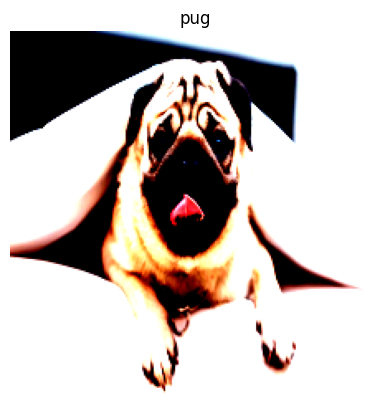

In [46]:
# отправляем на девайс
model_VGG.to(DEVICE)
# убеждаемся, что модель в режиме предсказания
model_VGG.eval()

# отображение переданной картинки
plt.imshow(torch.permute(image_tensor, (1, 2, 0)))
plt.axis('off')

# Замер времени выполнения предсказания
start_time = time.time()
# Синхронизация перед запуском предсказания
if DEVICE.type == 'cuda':
    torch.cuda.synchronize()

with torch.inference_mode():
    outputs = model_VGG(image_tensor.to(DEVICE).unsqueeze(0))
    # Синхронизация после предсказания
    if DEVICE.type == 'cuda':
        torch.cuda.synchronize()
# время после выполнения предсказания
end_time = time.time()
# время, сколько длилось предсказание
inference_time = end_time - start_time
print(f"Время выполнения предсказания: {inference_time:.6f} секунд")

# Преобразование выходов модели в вероятности
probabilities = F.softmax(outputs, dim=1)

# Получение топ-5 предсказаний
top5_prob, top5_catid = torch.topk(probabilities, 5)

# Перенос данных на CPU и преобразование в списки
top5_prob = top5_prob.cpu().squeeze().tolist()
top5_catid = top5_catid.cpu().squeeze().tolist()

# Декодирование индексов классов в имена
top5_classes = [decode(catid) for catid in top5_catid]

# Вывод топ-5 предсказаний
for i in range(len(top5_classes)):
    print(f"{i+1}. {top5_classes[i]}: {top5_prob[i]*100:.2f}%")

# Установка названия изображения как наивысшая предсказанная категория
plt.title(top5_classes[0])
plt.show()

# Сохранение топ-5 предсказаний в словарь
top5_predictions = {
    "categories": top5_classes,
    "probabilities": top5_prob
}

# plt.title(decode(outputs.argmax().item()));

In [39]:
model_VGG.eval()  # Перевод модели в режим оценки

# Сохранение только state_dict (рекомендуется)
torch.save(model_VGG.state_dict(), '../../models/sasha/model_VGG_state_dict.pth')

In [47]:
# Загружаем JSON из URL
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
response = requests.get(url)
labels = response.json()

# Сохраняем JSON в файл
with open("imagenet_class_index.json", "w") as json_file:
    json.dump(labels, json_file)

print("Файл успешно сохранен как imagenet_class_index.json")

Файл успешно сохранен как imagenet_class_index.json


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model_res = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
tu.get_model_summary(model_res, fake_batch)

In [9]:
model_res.eval()  # Перевод модели в режим оценки

# Сохранение только state_dict (рекомендуется)
torch.save(model_res.state_dict(), '../../models/sasha/model_res_state_dict.pth')